# Questions by Daniel Majer

### Import modules

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import Callable

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

tidy_data: pd.DataFrame = pd.read_csv('./data/tidy_seer_breast_cancer_dataset.csv')

## Question 1.1
    What's the range of ages in each race group, when most probable that women can be affected by breast cancer based on this data set?

1. Get the ages for each groups.

2. Display grouped ages as a boxplot we can visualize the spread of the ages and getting the values for the interquartiles.

3. After that, rearrange the obtained datas and display them as a histogram for easier interpretation.


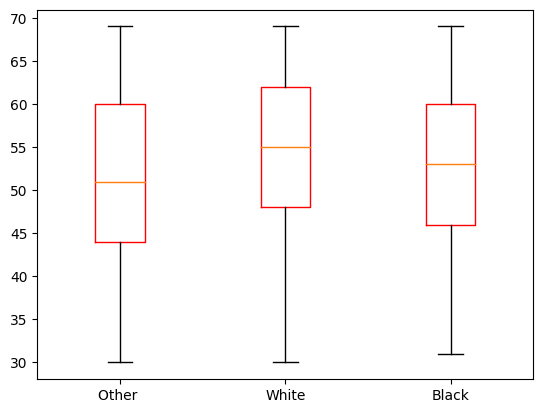

In [2]:
def get_age_series_by_race(tidy_data: pd.DataFrame) -> tuple[list[str], list[pd.Series]]:
    '''Create list of series for each race with the age values.
    '''
    races_ls: list[pd.Series] = []
    races_labels: list[str]   = []
    for race in tidy_data['race'].unique():
        races_ls.append(tidy_data.loc[(tidy_data['race'] == race)]['age'])
        races_labels.append(race)

    return races_ls, races_labels

def get_age_interquartile(df: pd.DataFrame, labels: list[str], bp: list[dict[str, float]]) -> pd.DataFrame:
    ''' Get interquartile values of each box in the plot 
        and fetch them into a data frame as it can be plotted in a histogram.
    '''

    tmp_dict: dict[str, list[int]] = {}

    for i in range(len(labels)):
        
        tmp_dict.setdefault(labels[i], [])

        lower_quartile: float = bp['boxes'][i].get_ydata()[1]
        upper_quartile: float = bp['boxes'][i].get_ydata()[2]
        
        race_ages:          pd.DataFrame = df.loc[(df['race'] == labels[i])]
        most_affected_ages: list[int]    = list(set(race_ages[race_ages['age'].between(lower_quartile, upper_quartile)]['age']))
        
        tmp_dict[labels[i]] += most_affected_ages
        
    df_dict = {'race': [], 'age': []}

    for race, ages in tmp_dict.items():
        df_dict['race'] += [race.strip(' ') for _ in range(len(ages))]
        df_dict['age']  += ages


    return pd.DataFrame(df_dict)


# BOXPLOT
races_ls, races_labels = get_age_series_by_race(tidy_data)
boxplt_ages_by_races: dict[str, dict | list] = plt.boxplot(
                                                    races_ls, 
                                                    boxprops=dict(color='red'),
                                                    labels=races_labels
)

---

### Conclusion of the boxplots:
- All the groups are similarly affected in the same range of ages. 
- The most outstanding is the "white" (caucasian) race group, where the range amount seems the same as the others, 
but the higher probability of breast cancer is shifted to the older ages by about 5 years or so.

---

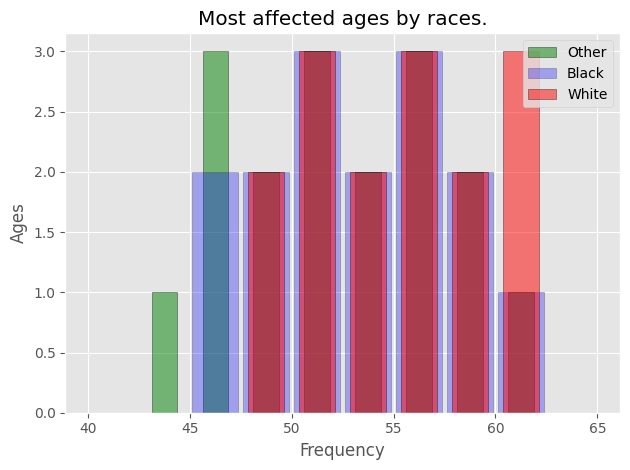

In [3]:
# BAR PLOT INIT
boxplt_interquartiles: pd.DataFrame = get_age_interquartile(tidy_data, 
                                                            races_labels, 
                                                            boxplt_ages_by_races
                                      )

plt.style.use('ggplot')
plt.title('Most affected ages by races.')

# OTHER
plt.hist(boxplt_interquartiles.loc[(boxplt_interquartiles['race'] == 'Other')]['age'], 
                                    rwidth = 0.5, 
                                    alpha = 0.5, 
                                    edgecolor='black',
                                    color='green',
                                    bins=10, 
                                    label='Other',
                                    range=[40,65]
)

# BLACK
plt.hist(boxplt_interquartiles.loc[(boxplt_interquartiles['race'] == 'Black')]['age'],
                                    rwidth = 0.9,
                                    alpha = 0.3,
                                    edgecolor='black',
                                    color='blue',
                                    bins=10,
                                    label='Black',
                                    range=[40,65]
)

# OTHER
plt.hist(boxplt_interquartiles.loc[(boxplt_interquartiles['race'] == 'White')]['age'], 
                                    rwidth = 0.7,
                                    alpha = 0.5,
                                    edgecolor='black',
                                    color='red',
                                    bins=10,
                                    label='White',
                                    range=[40,65]
)

plt.legend(loc='upper right')
plt.xlabel('Frequency')
plt.ylabel('Ages')
plt.tight_layout()
plt.show()

---

### Conclusion of the histogram plot
    1. By this data set we can say that the "white" (caucasian) group seems affected in a slightly older age by the breast cancer, and the "other" (American Indian/AK Native, Asian/Pacific Islander) group is affected from a younger age, but with less chance in older ages.

    2. These values could be affected by various factors:
    
- general quality of the healthcare system of that region (medicines which affect more the female hormone balances)
- genetics

- general bad diet habbits, like overweight or excess alcohol consumption, etc..
    

But from these datas we cannot say anything for sure, because of the missing informations.

---

## 1.2 Question
    In those ages which suffer the most from breast cancer, what are the frequencies of the 6th stage categories?

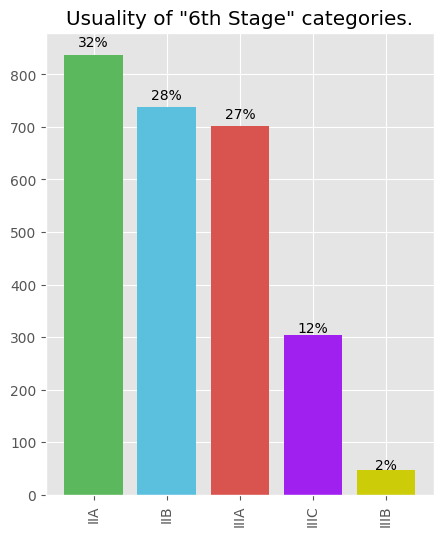

In [4]:
def get_most_affected_records(df: pd.DataFrame) -> pd.DataFrame:
      ages: list[int] = set(df.loc[:, 'age'])
      min_age:    int = min(ages)
      max_age:    int = max(ages)

      # Filter for the obtained range, 
      # and remove the "Unnamed" column left behind from a previous index column.
      return (tidy_data[tidy_data['age'].between(min_age, max_age)]
                              .loc[:, ~tidy_data.columns.str.contains('^Unnamed')]
      )

most_affected_pacients: pd.DataFrame = get_most_affected_records(boxplt_interquartiles)

frequencies: int = most_affected_pacients['6th_stage'].value_counts()

# Get the sum of cases for the percentage annotations in the plot.
total_cases: int = frequencies.sum()

colors_list = ['#5cb85c', 
               '#5bc0de',
               '#d9534f', 
               '#A020F0',
               '#CCCC09'
            ]

ax = (most_affected_pacients['6th_stage'].value_counts()
                                        .plot(kind      = 'bar',
                                              width     = 0.8,
                                              figsize   = (5,6),
                                              color     = colors_list,
                                              edgecolor = None
                                        )
)

ax.set_title('Usuality of "6th Stage" categories.')

# Add the annotations
for p in ax.patches:

    width:  np.float64 = p.get_width()
    height: np.float64 = p.get_height()

    x, y = p.get_xy()

    ax.annotate(f'{(height / total_cases):.0%}', 
                (x + width/2, y + height*1.02), 
                ha='center'
    )


---

### Conclusion of the bar plot

    The most common "6th Stage" category is the IIA type.

    Which means that the in most of the cases there is no evidence for the presence of tumor inside the actual breast, but the cancer has spread to 1 to 3 axillary lymph nodes, without further spread to other distant body parts.

    The general sizes of this type of cancer are T1 (< 2cm) and T2 (2cm < x < 5cm).
   
    The least probable is the IIIB type which means that the tumor has spread to the chest wall or caused swelling or ulceration of the breast, or it is diagnosed as inflammatory breast cancer. It may or may not have spread to up to 9 axillary or internal mammary lymph nodes. It has not spread to other parts of the body.

    The general size of this type is T4 (larger than 5cm).
   
---

## 2. Question

    Still using the age range of the most effected echelon by the breast cancer,
    as a rough estimation, how the survival rate is affected by the age?

1. First We need to use a more regular value unit, such as percentage (the most common) to represent the survival rate for each age.

2. Create a line plot for the obtained rates.

3. Calculate and fetch the regression line onto the previous plot.

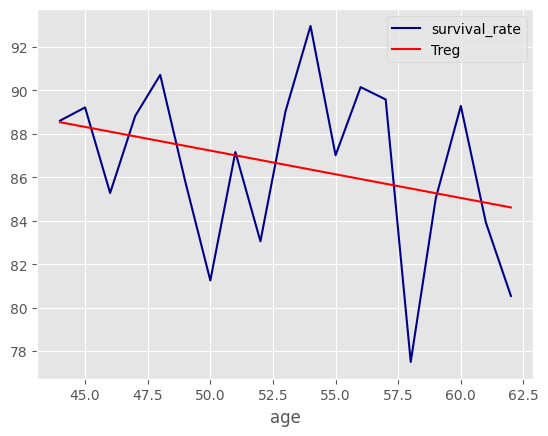

In [5]:
def get_survival_rate_by_age(data: pd.DataFrame) -> pd.DataFrame:

    total_by_age: pd.DataFrame = (data.groupby('age', as_index=True)
                                                        .agg(total = ('status', 'count'))
    )

    survival_rates: pd.DataFrame = (data.loc[(most_affected_pacients['status'] == 'Alive')]
                                                        .groupby('age', as_index=True)
                                                        .agg(survivals = ('status', 'count'))
    )

    merged_df = pd.concat([survival_rates, total_by_age], axis=1, join="inner")

    merged_df['survival_rate'] = (merged_df['survivals'] / merged_df['total']) * 100
    merged_df.drop(columns=['survivals', 'total'], inplace=True)

    return merged_df.reset_index()

def plot_regression_line(df: pd.DataFrame, x_col: str, y_col: str, scatter=False) -> None:

    if scatter:
        ax = df.plot.scatter(x=x_col, y=y_col, c = 'DarkBlue')
    else:
        ax = df.plot(x=x_col, y=y_col, c = 'DarkBlue')

    g = np.polyfit(df[x_col], df[y_col],1)
    f = np.poly1d(g)

    df.insert(2, 'Treg', f(df[x_col]))
    _  = df.plot(x=x_col, y='Treg', color='Red', ax=ax)

df_survival_rate: pd.DataFrame = get_survival_rate_by_age(most_affected_pacients)
plot_regression_line(df_survival_rate, 'age', 'survival_rate')


---

### Conclusion obtained from the linear regression, representing the relationship of the survival rates and the ages.

    Even though the cancer cells exhibits slower growth and spreading in the elderly generation, unfortunately the chance of survival is dropping by age. Usually, it is because of the already weaker defense system.

---

## 3. Question

    Visualizing on a similar way as in the previous question, how the survival rate is affected by the amount of months the cancer is present in the host?

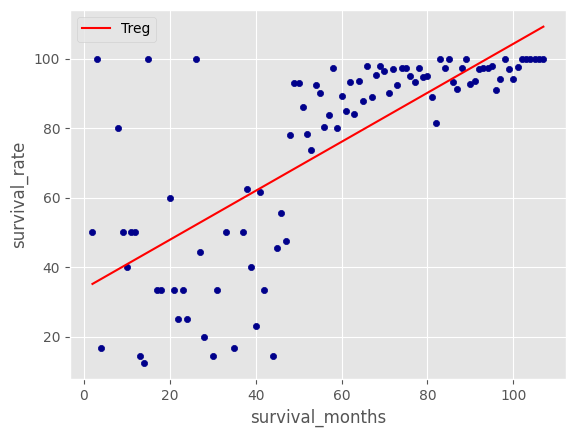

In [6]:
def get_survival_rate_by_months(df: pd.DataFrame) -> pd.DataFrame:
    
    survivals_by_months: pd.DataFrame = (df.loc[df['status'] == 'Alive']
                                                            .groupby('survival_months').agg(Alive =  ('status', 'count'))
    )

    deaths_by_months: pd.DataFrame = (df.groupby('survival_months').agg(Total =  ('status', 'count'))
    )

    merged_df = pd.concat([survivals_by_months, deaths_by_months], axis=1, join="inner").reset_index()
    merged_df['survival_rate']  = (merged_df['Alive'] / merged_df['Total']) * 100

    return merged_df

survival_rates_by_months = get_survival_rate_by_months(most_affected_pacients)
plot_regression_line(survival_rates_by_months, 'survival_months', 'survival_rate', scatter=True)

---


### Conclusion obtained from the linear regression of the relationship between the amount of months the cancer is present and survival rate.

    In the first 40-45 months the survival rates are really different from each other, with lots of outliers. Which indicates that the chances are vary quiet a lot in each cases.

    But as the dots are indicating the survival chances jump radically after ~50 months. 

    So the longer the cancer is present in the body, it is more pronounced that the body can fight it effectively, so the chances of the survival is much higher.

---